In [ ]:
!pip install pymorphy2 -q

In [ ]:
!git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
import sys; sys.path.append('./stepik-dl-nlp')

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import pymorphy2
import re

import matplotlib.pyplot as plt
%matplotlib inline

import collections

import torch
from torch import nn
from torch.nn import functional as F

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import dlnlputils
from dlnlputils.data import tokenize_text_simple_regex, tokenize_corpus, build_vocabulary, \
    vectorize_texts, SparseFeaturesDataset
from dlnlputils.pipeline import train_eval_loop, predict_with_model, init_random_seed

init_random_seed()

In [ ]:
morph = pymorphy2.MorphAnalyzer()

def Lemmatization(text):
  text = text.lower()
  text = re.sub(r'[^\w\s]', '', text)
  words = text.split()
  return [morph.parse(w)[0].normal_form for w in words]

In [ ]:
train = pd.read_csv('corpuscopy.csv', sep = ';')
train

,label,metadata,target,Unnamed: 3
0,Авто,"Продажа автомобилей, купить авто в Москве и Мо...",0,NaN
1,Авто,Каталог автомобилей - новые легковые авто в он...,0,NaN
2,Авто,"Geely ""Санрайз Групп"",Подберите Ваш Geely,OKAV...",0,NaN
3,Авто,"Выкуп авто в автосалоне «Red-auto»,",0,NaN
4,Авто,"Акции | Официальный дилер ""Red Auto"" в Москве,",0,NaN
...,...,...,...,...
1485,Медицина,МЕДИЦИНА. Введение — Большая Медицинская Энцик...,23,NaN
1486,Медицина,"Виды медицинской помощи,Квартирная помощь дост...",23,NaN
1487,Медицина,"Учебный портал Альфа-образование,Категории кур...",23,NaN
1488,Медицина,"Словарь медицинских терминов,Словарь медицинск...",23,NaN


In [ ]:
dop = pd.read_csv('keywords_label.csv', sep = ';')
dop

,label,keywords
0,Бухгалтерские услуги,бухгалтерский бухгалтерия налоги налог отчетно...
1,Грузоперевозки и транспортные услуги,грузоперевозка грузовой транспорт логистика ск...
2,Создание и продвижение сайтов,веб-дизайн создание продвижение веб дизайн веб...
3,Юридические услуги,юридический юрист гражданский право уголовный ...
4,Бытовая техника,бытовой техника кухонный электрический кухня х...
5,Доставка воды,доставка бутилированный вода минеральный питье...
6,Доставка готовых блюд и продуктов,доставка еда готовый блюдо сервис ресторанный ...
7,Кулинария,кулинария рецепт порция приготовление пища кул...
8,Домашние животные,домашний животное зверь собака кошка птица рыб...
9,Канцелярские товары,канцелярия канцелярский замазка калькулятор ли...


In [ ]:
len(train.label.value_counts())

52

In [ ]:
train.label.value_counts()

Грузоперевозки и транспортные услуги           34
Юридические услуги                             31
Ремонт                                         31
Парфюмерия и косметика                         31
Банки и кредиты                                31
Театры                                         31
Рестораны                                      30
Бытовая техника                                30
Домашние животные                              30
Российский туризм                              30
Кулинария                                      30
Игры                                           29
Музыка                                         29
Создание и продвижение сайтов                  29
Спорт                                          29
Инвестиции                                     29
Танцы                                          29
Зарубежный туризм                              29
Товары для детей                               29
Дополнительное образование и курсы             29


In [ ]:
target = train.label
encoder = LabelEncoder().fit(target)
target = encoder.transform(target)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    train.metadata, target,
    random_state = 40,
    test_size = 0.2,
    shuffle = True
)

In [ ]:
X_train = pd.concat([X_train, dop['keywords']], axis = 0)

In [ ]:
y_train = pd.concat([pd.Series(y_train), pd.Series(encoder.transform(dop['label']))], axis = 0)

In [ ]:
def Tokenizer(txt, min_token_size = 5):
    txt = txt.replace(',', ' ')
    txt = re.sub(r'(?<=[а-я])(?=[А-Я])', ' ', txt)
    txt = txt.lower()
    txt = re.sub(r'[^\w\s]', '', txt)
    all_tokens = re.findall(r'\b\w+\b', txt)
    all_tokens = Lemmatization(' '.join(all_tokens))
    # all_tokens = set(all_tokens)
    return [token for token in all_tokens if len(token) >= min_token_size]

In [ ]:
pip install catboost -q

In [ ]:
# for classifier use Logloss, CrossEntropy, MultiClass, MultiClassOneVsAll or custom objective object
# CatBoostClassifier(l2_leaf_reg = 1e-1, loss_function = 'MultiClass', depth = 5, n_estimators = 100, learning_rate = 0.2)
# SVC(probability = True, C = 2, kernel = 'sigmoid')
from catboost import CatBoostClassifier
# LogisticRegression(class_weight = 'balanced', random_state = 0)

from joblib import dump, load

sklearn_pipeline = Pipeline((('vect', TfidfVectorizer(tokenizer = Tokenizer,
                                                      max_df = 0.8,
                                                      min_df = 5)),
                             ('cls', LogisticRegression(class_weight = 'balanced', random_state = 0))))
sklearn_pipeline.fit(X_train, y_train);

sklearn_train_pred = sklearn_pipeline.predict_proba(X_train)
sklearn_train_loss = F.cross_entropy(torch.from_numpy(sklearn_train_pred),
                                                 torch.from_numpy(np.array(y_train)))
print('Среднее значение функции потерь на обучении', float(sklearn_train_loss))
print('Доля верных ответов', accuracy_score(y_train, sklearn_train_pred.argmax(-1)))
print()

sklearn_test_pred = sklearn_pipeline.predict_proba(X_test)
sklearn_test_loss = F.cross_entropy(torch.from_numpy(sklearn_test_pred),
                                                torch.from_numpy(np.array(y_test)))
print('Среднее значение функции потерь на валидации', float(sklearn_test_loss))
print('Доля верных ответов', accuracy_score(y_test, sklearn_test_pred.argmax(-1)))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Среднее значение функции потерь на обучении 3.7339241420198492
Доля верных ответов 0.844855305466238

Среднее значение функции потерь на валидации 3.782433463678635
Доля верных ответов 0.6711409395973155


In [ ]:
dump(sklearn_pipeline, 'kakos_pipeline.joblib')

['kakos_pipeline.joblib']

In [ ]:
kakos = load('kakos_pipeline.joblib')

In [ ]:
categories = ['Авто', 'Банки и кредиты', 'Беременность и роды', 'Билеты',
                  'Бухгалтерские услуги', 'Бытовая техника',
                  'Грузоперевозки и транспортные услуги', 'Дизайн интерьера',
                  'Домашние животные', 'Дополнительное образование и курсы',
                  'Доставка воды', 'Доставка готовых блюд и продуктов',
                  'Доступ в интернет и мобильная связь', 'Зарубежный туризм',
                  'Здоровое питание', 'Игры', 'Инвестиции', 'Канцелярские товары',
                  'Кино', 'Книги', 'Компьютерная техника', 'Кулинария', 'Мебель',
                  'Медицина', 'Мото', 'Музыка', 'Одежда и обувь', 'Охота',
                  'Парфюмерия и косметика', 'Подарки и цветы', 'Покупка и аренда',
                  'Принтеры и МФУ', 'Прокат автомобилей', 'Работа', 'Ремонт',
                  'Рестораны', 'Российский туризм', 'Рыбалка', 'Свадьба',
                  'Сельскохозяйственное оборудование и техника',
                  'Смартфоны и гаджеты', 'Создание и продвижение сайтов', 'Спорт',
                  'Танцы', 'Театры', 'Телевидение', 'Товары для детей',
                  'Товары для дома', 'Форекс', 'Фото, видео и аудиотехника',
                  'Школа и вуз', 'Юридические услуги']

In [ ]:
def make_predict(texts):
  prediction = kakos.predict(texts)
  prediction = [categories[i] for i in prediction]
  return prediction

texts = ['Сельское хозяйство', 'Клиника здоровго позвоночника', 'Танцевальная студия в Магнитогорске записаться по телефону']
print(make_predict(texts))

['Сельскохозяйственное оборудование и техника', 'Медицина', 'Танцы']


In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV

vectorizer = TfidfVectorizer(tokenizer=Tokenizer,
                             max_df = 0.8,
                             min_df = 10)

# Преобразуем наши данные в матрицу TF-IDF
X_train_tfidf = vectorizer.fit_transform(X_train)

# Создаем объект TruncatedSVD
svd = TruncatedSVD(n_components = 200)

# Применяем TruncatedSVD к матрице TF-IDF
X_train_svd = svd.fit_transform(X_train_tfidf)

# Теперь вы можете использовать X_train_svd для обучения вашего классификатора
# cls = CatBoostClassifier(l2_leaf_reg = 1e+1, n_estimators = 100, learning_rate = 0.1)
# cls = LogisticRegression()
cls = SVC(probability = True, C = 1, kernel = 'sigmoid')
cls.fit(X_train_svd, y_train)

# param_grid = {
#     'C': np.arange(1, 3),
#     # 'kernel': ['sigmoid', 'rbf', 'precomputed', 'poly'],
#     'tol': [1e-3, 1e-4, 1e-5],
# }

# search = GridSearchCV(cls, param_grid, n_jobs = -1, cv = 5, refit = True, scoring = 'accuracy')
# search.fit(X_train_svd, y_train)
# print(search.best_params_)

X_test_tfidf = vectorizer.transform(X_test)
X_test_svd = svd.transform(X_test_tfidf)

sklearn_train_pred = cls.predict_proba(X_train_svd)
sklearn_train_loss = F.cross_entropy(torch.from_numpy(sklearn_train_pred),
                                                 torch.from_numpy(np.array(y_train)))
print('Среднее значение функции потерь на обучении', float(sklearn_train_loss))
print('Доля верных ответов', accuracy_score(y_train, sklearn_train_pred.argmax(-1)))
print()

sklearn_test_pred = cls.predict_proba(X_test_svd)
sklearn_test_loss = F.cross_entropy(torch.from_numpy(sklearn_test_pred),
                                                torch.from_numpy(np.array(y_test)))
print('Среднее значение функции потерь на валидации', float(sklearn_test_loss))
print('Доля верных ответов', accuracy_score(y_test, sklearn_test_pred.argmax(-1)))

# print('Предсказанные классы', sklearn_test_pred.argmax(-1))
# print('Предсказанные классы', encoder.inverse_transform(sklearn_test_pred.argmax(-1)))

Среднее значение функции потерь на обучении 3.6729551540547822
Доля верных ответов 0.7256410256410256

Среднее значение функции потерь на валидации 3.7199406391256735
Доля верных ответов 0.6035805626598465


In [ ]:
encoder.inverse_transform([i for i in range(0, 52)])

array(['Авто', 'Банки и кредиты', 'Беременность и роды', 'Билеты',
       'Бухгалтерские услуги', 'Бытовая техника',
       'Грузоперевозки и транспортные услуги', 'Дизайн интерьера',
       'Домашние животные', 'Дополнительное образование и курсы',
       'Доставка воды', 'Доставка готовых блюд и продуктов',
       'Доступ в интернет и мобильная связь', 'Зарубежный туризм',
       'Здоровое питание', 'Игры', 'Инвестиции', 'Канцелярские товары',
       'Кино', 'Книги', 'Компьютерная техника', 'Кулинария', 'Мебель',
       'Медицина', 'Мото', 'Музыка', 'Одежда и обувь', 'Охота',
       'Парфюмерия и косметика', 'Подарки и цветы', 'Покупка и аренда',
       'Принтеры и МФУ', 'Прокат автомобилей', 'Работа', 'Ремонт',
       'Рестораны', 'Российский туризм', 'Рыбалка', 'Свадьба',
       'Сельскохозяйственное оборудование и техника',
       'Смартфоны и гаджеты', 'Создание и продвижение сайтов', 'Спорт',
       'Танцы', 'Театры', 'Телевидение', 'Товары для детей',
       'Товары для дома', 



---



In [ ]:
data = train.copy()

In [ ]:
rs = []
for i in data.metadata:
  rs.append(pizdA(i))
data['lem'] = rs
data

,label,metadata,target,lem
0,Принтеры и МФУ,Принтеры и МФУ | Принтеры для дома и офиса | B...,31,"[принтер, принтер, brother, устройство, бизнес..."
1,Принтеры и МФУ,"Принтеры Canon - Canon Russia,ПринтерыИщете ус...",31,"[принтер, canon, canon, russia, принтер, искат..."
2,Принтеры и МФУ,"Каталог принтеров, сканеров и МФУ HP в фирменн...",31,"[каталог, принтер, сканер, фирменный, магазин,..."
3,Принтеры и МФУ,KYOCERA — Принтеры и МФУ | Сайт магазина Киосе...,31,"[kyocera, принтер, магазин, киосера, kyoceraка..."
4,Принтеры и МФУ,"Принтеры и периферия,Теги,Новости",31,"[принтер, периферия, новость]"
...,...,...,...,...
1946,Кулинария,Кулинарные рецепты - Кулинария дома на каждый ...,21,"[кулинарный, рецепт, кулинария, каждый, кулина..."
1947,Кулинария,"Кулинария с фото, сайт кулинарии, кулинария го...",21,"[кулинария, кулинария, кулинария, готовить, ку..."
1948,Кулинария,"Рецепты блюд- простая кулинария, вкусные рецеп...",21,"[рецепт, блюдо, простой, кулинария, вкусный, р..."
1949,Кулинария,Блог Ужин Дома: пошаговые рецепты с фото и вид...,21,"[пошаговый, рецепт, видео, совет, шефповар, ку..."


In [ ]:
vocab = {}
for i in data.lem:
  for j in i:
    if j not in vocab.keys():
      vocab[j] = 1
    else:
      vocab[j] += 1

vocab = {k: vocab[k] for k in sorted(vocab, key = vocab.get, reverse = True)}
print(len(vocab))
print({k: vocab[k] for k in list(vocab)[:20]})

19187
{'москва': 620, 'россия': 528, 'новый': 375, 'новость': 361, 'хороший': 342, 'купить': 318, 'охота': 315, 'работа': 310, 'доставка': 291, 'компания': 264, 'ремонт': 260, 'товар': 256, 'рубль': 253, 'отзыв': 244, 'ресторан': 243, 'который': 234, 'услуга': 233, 'онлайн': 232, 'танец': 228, 'смотреть': 225}


In [ ]:
cnt = 0
for i in vocab.values():
  if i >= len(data) * 0.8:
    cnt += 1
print(f'{cnt} токенов с частотой более 0.8')

cnt = 0
for i in vocab.values():
  if i <= 10:
    cnt += 1
print(f'{cnt} токенов c частотой менее 10')

0 токенов с частотой более 0.8
17604 токенов c частотой менее 10




---



In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from torch.optim.lr_scheduler import LambdaLR
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
model_name = 'DeepPavlov/rubert-base-cased'

In [ ]:
tokenized_texts_clear = [[] for i in range(len(train))]
for i in range(len(data.lem)):
  for j in data.lem[i]:
    if j not in vocab.keys() or vocab[j] <= 10:
      if j in vocab.keys():
        del vocab[j]

cnt = 0
for i in data.lem:
  for j in i:
    if j in vocab.keys():
      if j not in tokenized_texts_clear[cnt]:
        tokenized_texts_clear[cnt].append(j)
  cnt += 1

print(len(vocab))
print({k: vocab[k] for k in list(vocab)[:20]})
print(tokenized_texts_clear[0])

1583
{'москва': 620, 'россия': 528, 'новый': 375, 'новость': 361, 'хороший': 342, 'купить': 318, 'охота': 315, 'работа': 310, 'доставка': 291, 'компания': 264, 'ремонт': 260, 'товар': 256, 'рубль': 253, 'отзыв': 244, 'ресторан': 243, 'который': 234, 'услуга': 233, 'онлайн': 232, 'танец': 228, 'смотреть': 225}
['принтер', 'устройство', 'бизнес', 'портативный', 'услуга', 'управление', 'печать', 'почему', 'выбирать', 'струйный', 'многофункциональный', 'лазерный', 'линейка', 'подобрать', 'материал']


Text(0.5, 1.0, 'Длины текстов')

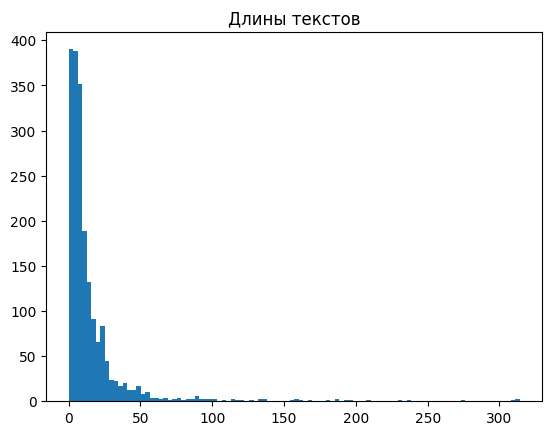

In [ ]:
import matplotlib.pyplot as plt
tokenized_texts_len = [len(i) for i in tokenized_texts_clear]
plt.hist(tokenized_texts_len, bins = 100)
plt.title('Длины текстов')

In [ ]:
pd.DataFrame(tokenized_texts_len).quantile(0.75)

0    16.0
Name: 0.75, dtype: float64

In [ ]:
!pip install transformers -q
!pip install pytorch-transformers -q

In [ ]:
vocabular = {}
cnt = 1
for i in vocab.keys():
  if i not in vocabular.keys():
    vocabular[i] = cnt
    cnt += 1
vocabular

In [ ]:
input_ids = [[vocabular[k] for k in x] for x in tokenized_texts_clear] # Сопоставление токена с номером
input_ids = pad_sequences( # Добавление паддинга
    input_ids,
    maxlen = 16,
    dtype = "long",
    truncating = "post",
    padding = "post"
)

attention_masks = [[float(i > 0) for i in seq] for seq in input_ids] # Маска внимания, ставит 1 там, где нет паддинга. Т.е. модель не будет учитывать добавленный паддинг, как значущую информацию

In [ ]:
target_bert = [[i] for i in target]

In [ ]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, target_bert,
    random_state = 40,
    test_size = 0.2
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state = 0,
    test_size = 0.2
)

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler = RandomSampler(train_data),
    batch_size = 5
)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler = SequentialSampler(validation_data),
    batch_size = 5
)

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )

    def forward(self, x):
        attn_output, _ = self.attention(x, x, x)
        x = self.norm1(x + attn_output)
        ffn_output = self.ffn(x)
        return self.norm2(x + ffn_output)

class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.transformer = TransformerBlock(embed_dim, num_heads=8)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text):
        embedded = self.embedding(text)
        transformer_out = self.transformer(embedded.transpose(0, 1))
        text_representation = transformer_out.mean(dim=0)
        return self.fc(text_representation)

model = TextClassificationModel(len(vocab) + 1, 128, 52)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = 52)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [ ]:
def lr_lambda(epoch):
    return 0.9 ** (epoch // 1)

optimizer = torch.optim.AdamW(model.parameters(), weight_decay = 2e-4, lr = 2e-2)
scheduler = scheduler = LambdaLR(optimizer, lr_lambda)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'figure.figsize': (10, 8), 'font.size': 14})
%matplotlib inline
from IPython.display import clear_output

def train(model, iterator, optimizer, scheduler, criterion):

    model.train()
    epoch_loss = 0
    history_loss = []
    history_acc = []

    for i, batch in enumerate(iterator):
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        logits = outputs[1]
        loss = criterion(logits, b_labels.squeeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        # b_input_ids, b_inputs_mask, b_labels = batch
        # optimizer.zero_grad()
        # outputs = model(b_input_ids)
        # loss = criterion(outputs, b_labels)
        # loss.backward()
        # optimizer.step()
        # epoch_loss += loss.item()

        # preds = torch.argmax(outputs, dim=1).detach().cpu().numpy()
        # targets = b_labels.to('cpu').numpy()
        # acc = accuracy_score(targets, preds)

        preds = torch.argmax(logits, dim = 1).detach().cpu().numpy()
        targets = b_labels.to('cpu').numpy()
        acc = accuracy_score(targets, preds)

        history_loss.append(loss.cpu().data.numpy())
        history_acc.append(acc)

        scheduler.step()

        if (i + 1) % 10 == 0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 8))
            clear_output(True)
            ax[0].plot(history_loss, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            ax[1].plot(history_acc, label='train accuracy')
            ax[1].set_xlabel('Batch')
            ax[1].set_title('Train Accuracy')
            plt.legend()
            plt.show()

    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator):

    model.eval()
    epoch_loss = 0
    valid_preds, valid_labels = [], []

    with torch.no_grad():

        for i, batch in enumerate(iterator):
            # b_input_ids, b_input_mask, b_labels = batch
            # with torch.no_grad():
            #     logits = model(b_input_ids)

            # label_ids = b_labels.to('cpu').numpy()
            # batch_preds = np.argmax(logits, axis = 1)
            # batch_labels = np.concatenate([label_ids])
            # valid_preds.extend(batch_preds)
            # valid_labels.extend(batch_labels)

            b_input_ids, b_input_mask, b_labels = batch
            with torch.no_grad():
                logits = model(b_input_ids, token_type_ids = None, attention_mask = b_input_mask)

            logits = logits[0].detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            batch_preds = np.argmax(logits, axis = 1)
            batch_labels = np.concatenate(label_ids)
            valid_preds.extend(batch_preds)
            valid_labels.extend(batch_labels)

        print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(accuracy_score(valid_labels, valid_preds) * 100))
        print(valid_labels)
        print(valid_preds)

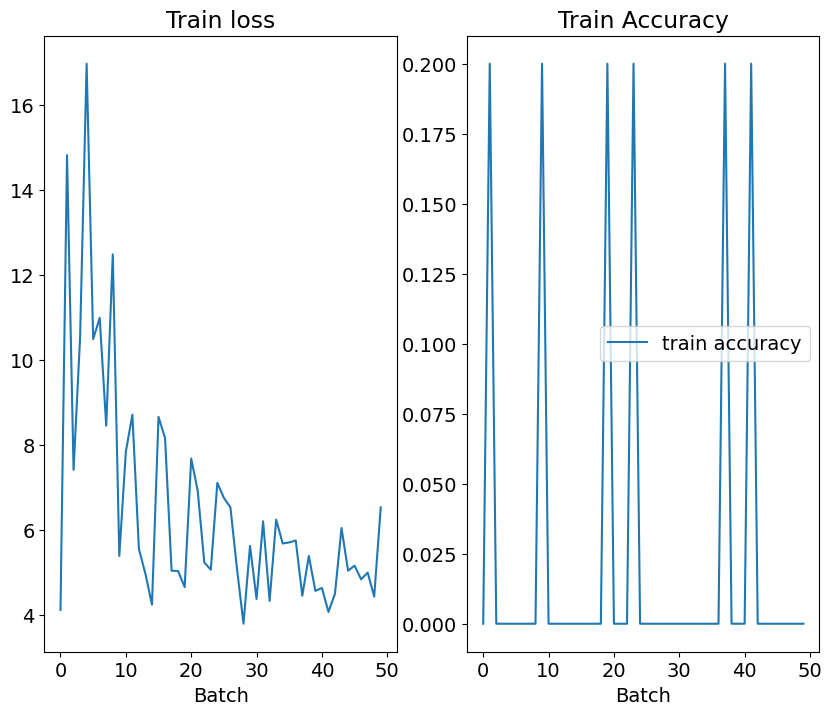

torch.Size([5, 1]) torch.Size([5, 52])
torch.Size([5, 1]) torch.Size([5, 52])
torch.Size([5, 1]) torch.Size([5, 52])


KeyboardInterrupt: ignored

In [ ]:
N_EPOCHS = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    train_loss = train(model, train_dataloader, optimizer, scheduler, criterion)
    valid_loss = evaluate(model, validation_dataloader)

In [ ]:
valid_loss = evaluate(model, validation_dataloader)

Процент правильных предсказаний на валидационной выборке: 2.56%
[20, 17, 2, 28, 34, 16, 13, 43, 34, 22, 25, 15, 40, 45, 0, 50, 30, 50, 21, 8, 31, 19, 28, 22, 49, 13, 3, 44, 50, 29, 23, 8, 31, 50, 36, 43, 21, 23, 11, 17, 29, 23, 38, 26, 31, 20, 2, 0, 29, 32, 35, 41, 6, 3, 0, 14, 43, 11, 37, 32, 50, 10, 21, 47, 24, 11, 46, 29, 11, 13, 40, 49, 15, 19, 5, 43, 25, 45, 2, 39, 18, 12, 17, 44, 50, 32, 12, 24, 37, 32, 20, 36, 48, 27, 22, 49, 23, 38, 26, 20, 27, 18, 11, 17, 48, 2, 20, 17, 16, 18, 36, 36, 50, 21, 15, 12, 48, 44, 8, 46, 18, 11, 35, 18, 5, 29, 13, 20, 14, 25, 36, 51, 26, 50, 26, 35, 43, 36, 51, 16, 14, 2, 45, 7, 2, 50, 45, 16, 0, 1, 11, 3, 51, 44, 49, 42, 9, 44, 0, 50, 41, 41, 35, 47, 32, 36, 32, 35, 49, 48, 35, 9, 29, 42, 3, 7, 21, 2, 32, 48, 3, 50, 46, 34, 48, 50, 31, 25, 11, 39, 19, 42, 41, 28, 36, 26, 9, 49, 4, 20, 19, 26, 32, 22, 21, 36, 16, 26, 50, 9, 21, 28, 14, 31, 37, 31, 21, 49, 8, 36, 33, 32, 18, 45, 43, 31, 44, 17, 19, 15, 27, 23, 4, 42, 4, 19, 33, 46, 41, 20, 2, 37, 49